In [1]:
import numpy as np
from scipy import fft, optimize
import NAFFlib as naf
import statistics as st
import matplotlib.pyplot as plt
import time
from IPython.display import display, Math
import re
import csv

# BPM Data

In [2]:
#Get data from all BPMs from sdds file
Name_xbpms = []
Name_ybpms = []
Pos_xbpms = np.zeros([1024, 168])
Pos_ybpms = np.zeros([1024, 167])
S_xbpms = np.zeros([1024, 168])
S_ybpms = np.zeros([1024, 167])
with open('data_Wed_Jun_28_20-13-14_2023') as output:
    Lines = output.readlines()
    index_ix = index_jx = 0
    index_iy = index_jy = 0
    init_i = 414
    for i, line in enumerate(Lines[1:]):
        Line = []
        #xBPM Names
        if i >= 67 and i < 95:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_xbpms.append(Line[:-1])
        
        #yBPM Names
        if i >= 241 and i < 269:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_ybpms.append(Line[:-1])
           
        #s and positions for xBPM
        if i > init_i:
            row = re.split("\s+", line)
            S_xbpms[index_ix][index_jx] = float(row[1])
            Pos_xbpms[index_ix][index_jx] = float(row[2])
            index_jx = (i - init_i)%168
            
            if (i - init_i)%168 == 0 and (i - init_i) != 0:
                index_ix += 1
        
        #s and positions for yBPM
        if i > init_i and i < 171423:
            row = re.split("\s+", line)
            S_ybpms[index_iy][index_jy] = float(row[6])
            Pos_ybpms[index_iy][index_jy] = float(row[7])
            index_jy = (i - init_i)%167
            
            if (i - init_i)%167 == 0 and (i - init_i) != 0:
                index_iy += 1
        
Name_xbpms = [item for row in Name_xbpms for item in row]
Name_ybpms = [item for row in Name_ybpms for item in row]

In [33]:
# Positions
init_turn = 0 # Starting turn
BPMx = Pos_xbpms.T[:, init_turn:] #np.loadtxt('BPMx.csv', delimiter=',')[:, init_turn:]
BPMy = Pos_ybpms.T[:, init_turn:] #np.loadtxt('BPMy.csv', delimiter=',')[:, init_turn:]

N_BPMx, N_turns = np.shape(BPMx) #(168, 1024-init_turn)
N_BPMy, _ = np.shape(BPMy) #(167, 1024-init_turn)

#Tunes
Nu_x_meas, Nu_y_meas = 28.235001748, 29.2290029334
nu_x_meas, nu_y_meas = Nu_x_meas%1, Nu_y_meas%1

x = np.linspace(init_turn, N_turns, N_turns)
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns

Standard deviation of First Horizontal BPM = 0.08086005371776343


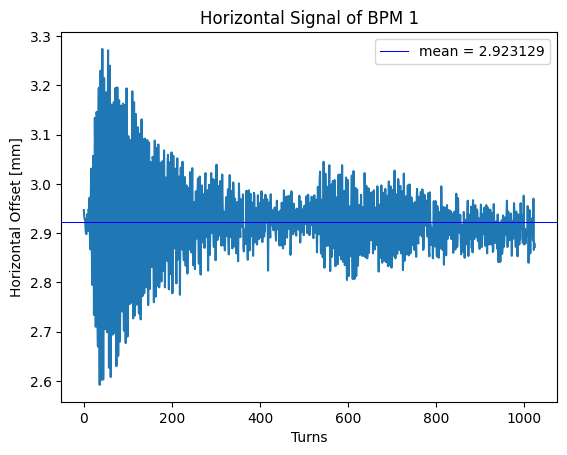

Standard deviation of First Vertical BPM = 0.14039846131415454


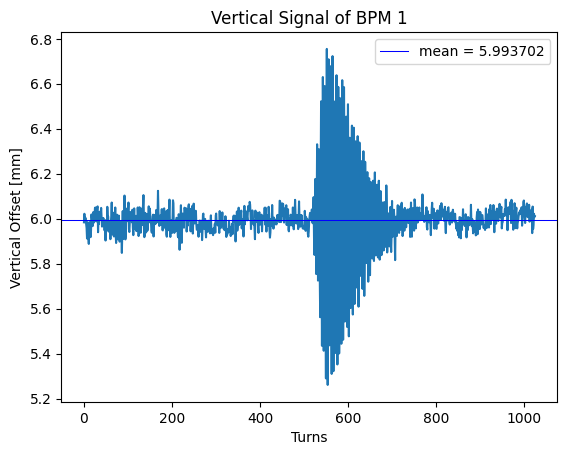

In [4]:
# Look at first BPM Signals
BPMx0 = BPMx[0]

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print("Standard deviation of First Horizontal BPM =", BPMx0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMx0)
plt.axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
plt.xlabel("Turns")
plt.ylabel("Horizontal Offset [mm]")
plt.title("Horizontal Signal of BPM 1")
plt.legend()
plt.show()

BPMy0 = BPMy[0]

BPMy0_mean = np.mean(BPMy0)
BPMy0_std = np.std(BPMy0)
print("Standard deviation of First Vertical BPM =", BPMy0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMy0)
plt.axhline(y = BPMy0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMy0_mean)
plt.xlabel("Turns")
plt.ylabel("Vertical Offset [mm]")
plt.title("Vertical Signal of BPM 1")
plt.legend()
plt.show()

0.23483365949119372


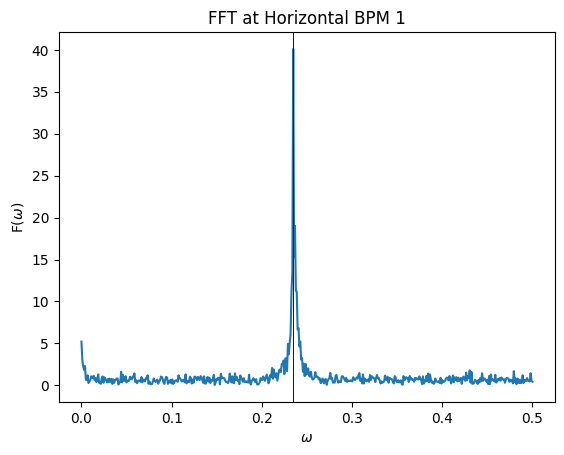

0.22896281800391388


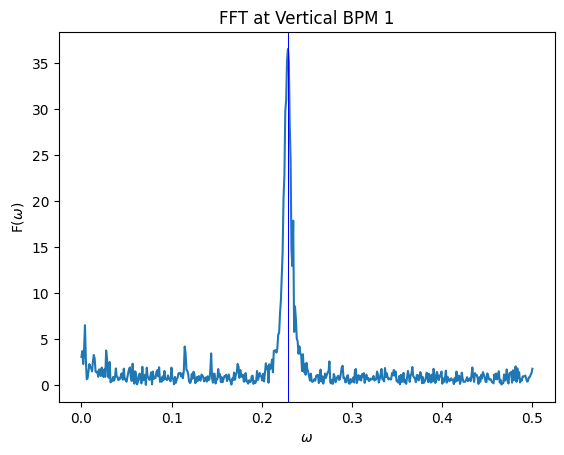

In [5]:
# Look at First BPM FFTs
BPMX0 = np.abs(fft.rfft(BPMx0)[1:])
BPMx0_Tune_scipy = Omega[np.argmax(BPMX0)]
print(BPMx0_Tune_scipy)
plt.plot(Omega, BPMX0)
plt.axvline(x = BPMx0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%BPMx0_Tune_scipy)
plt.title("FFT at Horizontal BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

BPMY0 = np.abs(fft.rfft(BPMy0)[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
print(BPMy0_Tune_scipy)
plt.plot(Omega, BPMY0)
plt.axvline(x = BPMy0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%BPMy0_Tune_scipy)
plt.title("FFT at Vertical BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

0.00016808850880467574 0.0010185889772997558


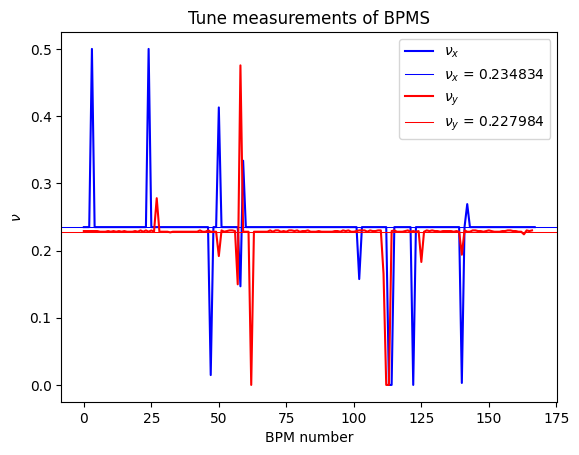

In [6]:
# Look at all FFTs to figure out Tune of machine
BPMx_Tune_Map = np.zeros(N_BPMx)
for i in range(N_BPMx):
    BPMX = np.abs(fft.rfft(BPMx[i])[1:]) 
    BPMx_Tune_Map[i] = Omega[np.argmax(BPMX)]
    # BPM 113 had a flat line

BPMy_Tune_Map = np.zeros(N_BPMy)
for i in range(N_BPMy):
    BPMY = np.abs(fft.rfft(BPMy[i])[1:])
    BPMy_Tune_Map[i] = Omega[np.argmax(BPMY)]

nu_x, nu_y = st.mode(BPMx_Tune_Map), st.mode(BPMy_Tune_Map)
#Difference from experiment
delta_nu_x, delta_nu_y = abs(nu_x_meas - nu_x), abs(nu_y_meas - nu_y)
print(delta_nu_x, delta_nu_y)

plt.plot(BPMx_Tune_Map, color = 'b', label = r"$\nu_x$")
plt.axhline(y = nu_x, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%nu_x)
plt.plot(BPMy_Tune_Map, color = 'r', label = r"$\nu_y$")
plt.axhline(y = nu_y, color = 'r', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%nu_y)
plt.xlabel("BPM number")
plt.ylabel(r"$\nu$")
plt.title("Tune measurements of BPMS")
plt.legend()
plt.show()

In [7]:
# Collect bad BPMs
def Bad_Bpms(Tune_Map, nu, N_BPM):
    Tune_Offset = np.abs(Tune_Map - np.ones(N_BPM)*nu)
    Bad_BPM = []
    for i, offset in enumerate(Tune_Offset):
        if offset > .01:
            Bad_BPM.append(i)
    return Bad_BPM

# Monte Carlo-Markov Chain Metropolis Hastings Method to find Amplitude

In [10]:
#Monte Carlo-Markov Chain Metropolis Hastings Functions by Yue Hao
def model(x0, x0p, xc, beta, alpha, tunex, eps_sr, eps_nl, xisige, nvs, phis, Nturn=N_turns):
    
    turns = np.arange(Nturn)
    phi = 2*np.pi*tunex
    
    cs = np.cos(turns*phi)
    sn = np.sin(turns*phi)
    m11 = cs + alpha*sn
    m12 = beta*sn
    
    alpha = 2*xisige*np.sin(np.pi*nvs*turns + phis)/nvs
    alpha02 = (2*xisige*np.sin(phis)/nvs)**2
    decay = np.exp(-(alpha**2 - alpha02)/2 - (eps_nl*turns)**2 - eps_sr*turns)
    return (m11*(x0 - xc) + m12*x0p)*decay + xc

def log_likelihood(theta, sigma, data):
    
    predicted_data = model(*theta, len(data)) 
    diff = predicted_data-data
    ss = sigma[0]*sigma[0]+sigma[1]*sigma[1]*data*data
    
    return -np.sum(diff*diff/2.0/ss) - np.sum(np.log(np.sqrt(ss)))#*len(diff)


def metropolis_hastings(lf, data, iters, pinitials, p_step,
                        sinitials=[1e-4,1e-4], s_step=[1e-4,1e-4]):
    psamples = np.zeros((iters, len(pinitials)))
    ssamples = np.zeros((iters, 2))
    p = np.array(pinitials)
    s = np.array(sinitials)
    pstep = np.array(p_step)
    sstep = np.array(s_step)
    changed = False
    old_lh = lf(p,s, data)
    i = 0
    while i<iters:
        p_n = p + np.random.normal(size=len(pinitials))*pstep
        s_n = s + np.random.normal(size=len(sinitials))*sstep
        if p_n[6] < 0: # SR_eps  > 0
            continue
        if p_n[7] < 0: # nl_eps  > 0
            continue
        if p_n[8] < 0: # xi*sige > 0
            continue
        if p_n[9] <= 0: # nuz > 0
            continue
        if p_n[10] > np.pi:
            p_n[10] -= 2*np.pi
        if p_n[10] < -np.pi: 
            p_n[10] += 2*np.pi
        if s_n[0] < 0: # error rms size >0
            continue
        if s_n[1] < 0: # error rms size >0
            continue
        if changed:
            #old_lh=lf(p,s, data)
            old_lh = new_lh
            
        new_lh = lf(p_n,s_n, data)#-((p_n[0]-data[0])*(p_n[0]-data[0])/2/s_n/s_n+np.log(s_n))#*len(data)
        if np.log(np.random.rand()+1.0e-10) < new_lh - old_lh:
            p,s = p_n,s_n
            changed = True
        else:
            changed = False
        psamples[i] = p
        ssamples[i] = s
        i += 1
    return psamples, ssamples

In [11]:
# Initial conditions for Horizontal BPMs
pinitials = [BPMx0[0], 0.0, BPMx0_mean, 1.0, 0, BPMx0_Tune_scipy, 0.0,  0.0, 0, 1e-2, 0.5]
p_step = [1e-3, 1e-3, 1e-3,  0,  0, 5e-7, 0, 0, 0, 0, 0]
sinitials = [1e-2, 0e-2]
s_step = [2e-4, 0e-3]
initial = 35

pinitials[6] = 0.0018
pinitials[7] = 0.0006
pinitials[8] = 0.00073
pinitials[9] = 1e-2
pinitials[10] = 1
p_step[6] = 1e-5
p_step[7] = 1e-5
p_step[8] = 1e-4
p_step[9] = 1e-4
p_step[10] = 3e-2
N_iter = 150000

# Run MCMCMH Simulation for Horizontal BPMs
begin = time.time()
# parr : iters x 11; sarr = iters x 2
parr, sarr = metropolis_hastings(log_likelihood, BPMx0[initial: N_turns//2 + initial], N_iter, 
                              pinitials, p_step, sinitials, s_step)
end = time.time()
print("Time elapsed for full model:", end - begin)

Time elapsed for full model: 33.12267994880676


/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_52631/3238975324.py:31: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  Ax[i][j*2 + 1].set_ylim([np.min(target), np.max(target)])


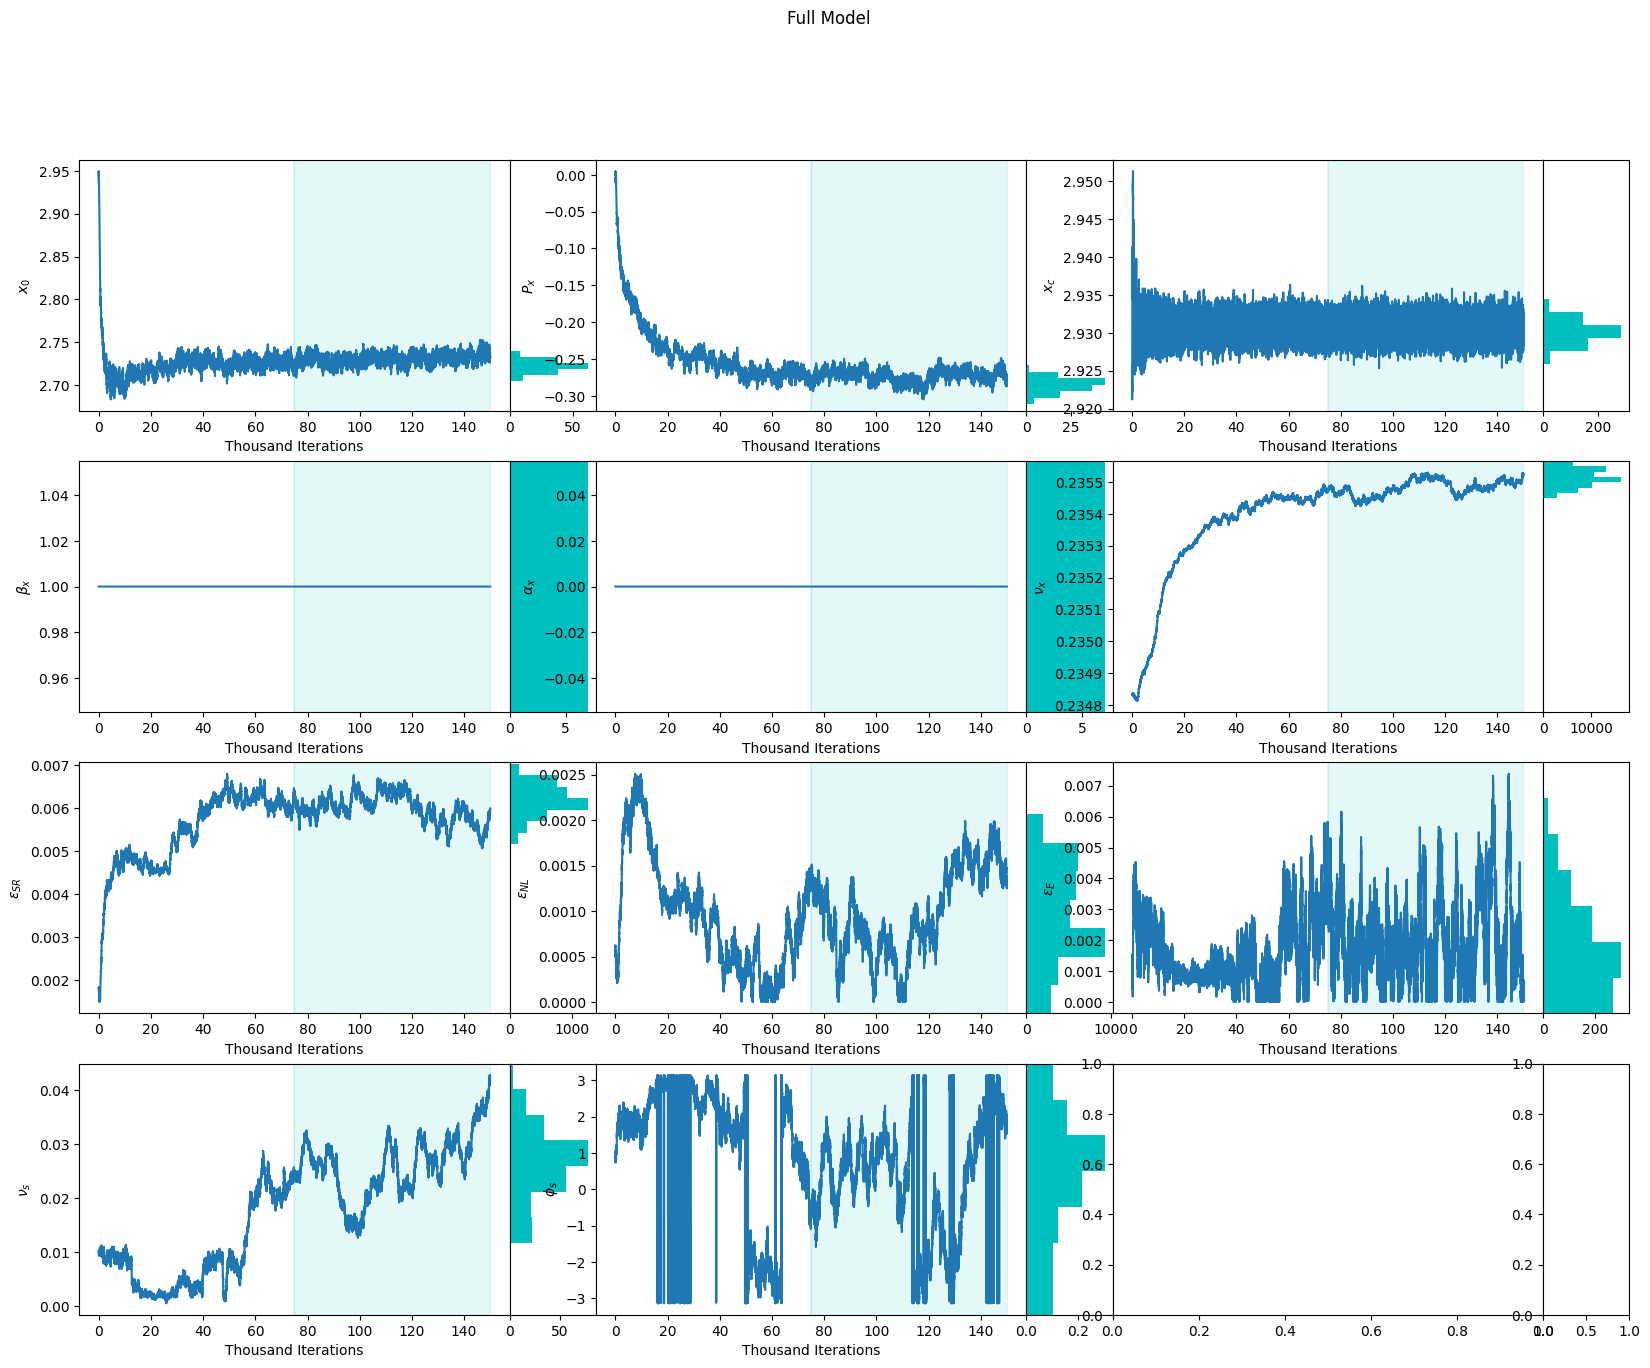

In [12]:
# Look at how variables change with # iterations
nrow = 4
ncol = 3
Theta_names = [r"$x_0$", r"$P_x$", r"$x_c$", r"$\beta_x$", r"$\alpha_x$", r"$\nu_x$", r"$\epsilon_{SR}$", 
              r"$\epsilon_{NL}$", r"$\epsilon_E$", r"$\nu_s$", r"$\phi_s$"]
N_var = len(Theta_names)
N_iter = len(parr)
fig, Ax = plt.subplots(nrow, ncol*2, gridspec_kw = {'width_ratios':[5, 1]*ncol}, figsize=(20, 15))
fig.suptitle('Full Model')
split = N_iter//2
x_iter = np.linspace(0, N_iter//1000, N_iter)
Center = []
Stddev = []

for i in range(nrow):
    for j in range(ncol):
        if i*ncol + j >= N_var:
            break
        target = parr.T[i*ncol + j]
        Ax[i][j*2].set_xlabel("Thousand Iterations")
        Ax[i][j*2].set_ylabel(Theta_names[i*ncol + j])
        Ax[i][j*2].plot(x_iter, target)
        Ax[i][j*2].axvspan(split/1000, N_iter/1000, alpha = 0.1, color = 'c')
        Ax[i][j*2].axvline(split/1000, color = 'c', alpha = 0.1)
        center, stddev = np.average(target[split:]), np.std(target[split:])
        Center.append(center)
        Stddev.append(stddev)
        
        hist_data,_,_ = Ax[i][j*2 + 1].hist(target[split:], orientation='horizontal', density=True, color='c', bins=7)
        Ax[i][j*2 + 1].set_xlim([0, np.max(hist_data)*1.1])
        Ax[i][j*2 + 1].set_ylim([np.min(target), np.max(target)])
        Ax[i][j*2 + 1].get_yaxis().set_visible(False)
        
        
plt.subplots_adjust(wspace=0.0)
plt.show()

[ 2.73066226e+00 -2.72839995e-01  2.93068708e+00  1.00000000e+00
  0.00000000e+00  2.35481433e-01  5.99064279e-03  9.80987715e-04
  2.01793460e-03  2.60066284e-02  2.35429614e-01]


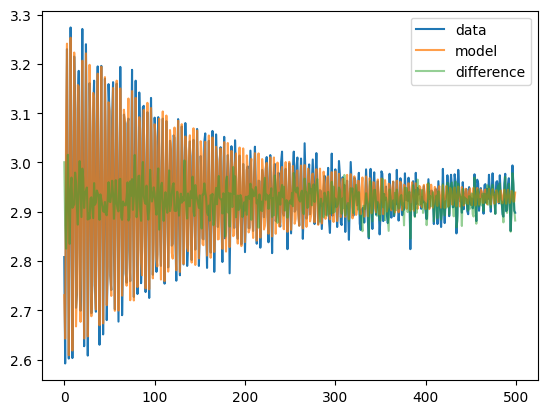

In [13]:
# Visualize Modeling for Horizontal BPMs
Center = np.array(Center)
Stddev = np.array(Stddev)
print(Center)

x_model = model(*Center, N_turns)
diff = BPMx0[initial: N_turns//2 + initial] - x_model[:N_turns//2] + BPMx0_mean
interval = 500#N_turns//2
initial = 35

plt.plot(BPMx0[initial: interval + initial], label = "data")
plt.plot(x_model[:interval], label = "model", alpha = .75)
plt.plot(diff[:interval], label = "difference", alpha = .5)

plt.legend()
plt.show()

In [14]:
# Initial conditions for Vertical BPMs
BPMY0 = np.abs(fft.rfft(BPMy[0])[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
pinitials = [BPMy[0, 0], 0.0, np.mean(BPMy[0]), 1.0, 0, BPMy0_Tune_scipy, 0.0,  0.0, 0, 1e-2, 0.5]
p_step = [1e-3, 1e-3, 1e-3,  0,  0, 5e-7, 0, 0, 0, 0, 0]
sinitials = [1e-2, 0e-2]
s_step = [2e-4, 0e-3]
initial = 535

pinitials[6] = 0.0018
pinitials[7] = 0.0006
pinitials[8] = 0.00073
pinitials[9] = 1e-2
pinitials[10] = 1
p_step[6] = 1e-5
p_step[7] = 1e-5
p_step[8] = 1e-4
p_step[9] = 1e-4
p_step[10] = 3e-2
N_iter = 150000

# Run MCMCMH Simulation for Vertical BPMs
begin = time.time()
# parr : iters x 11; sarr = iters x 2
parr, sarr = metropolis_hastings(log_likelihood, BPMy0[initial: ], N_iter, 
                              pinitials, p_step, sinitials, s_step)
end = time.time()
print("Time elapsed for full model:", end - begin)

Time elapsed for full model: 30.557954788208008


/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_52631/152406100.py:31: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  Ax[i][j*2 + 1].set_ylim([np.min(target), np.max(target)])


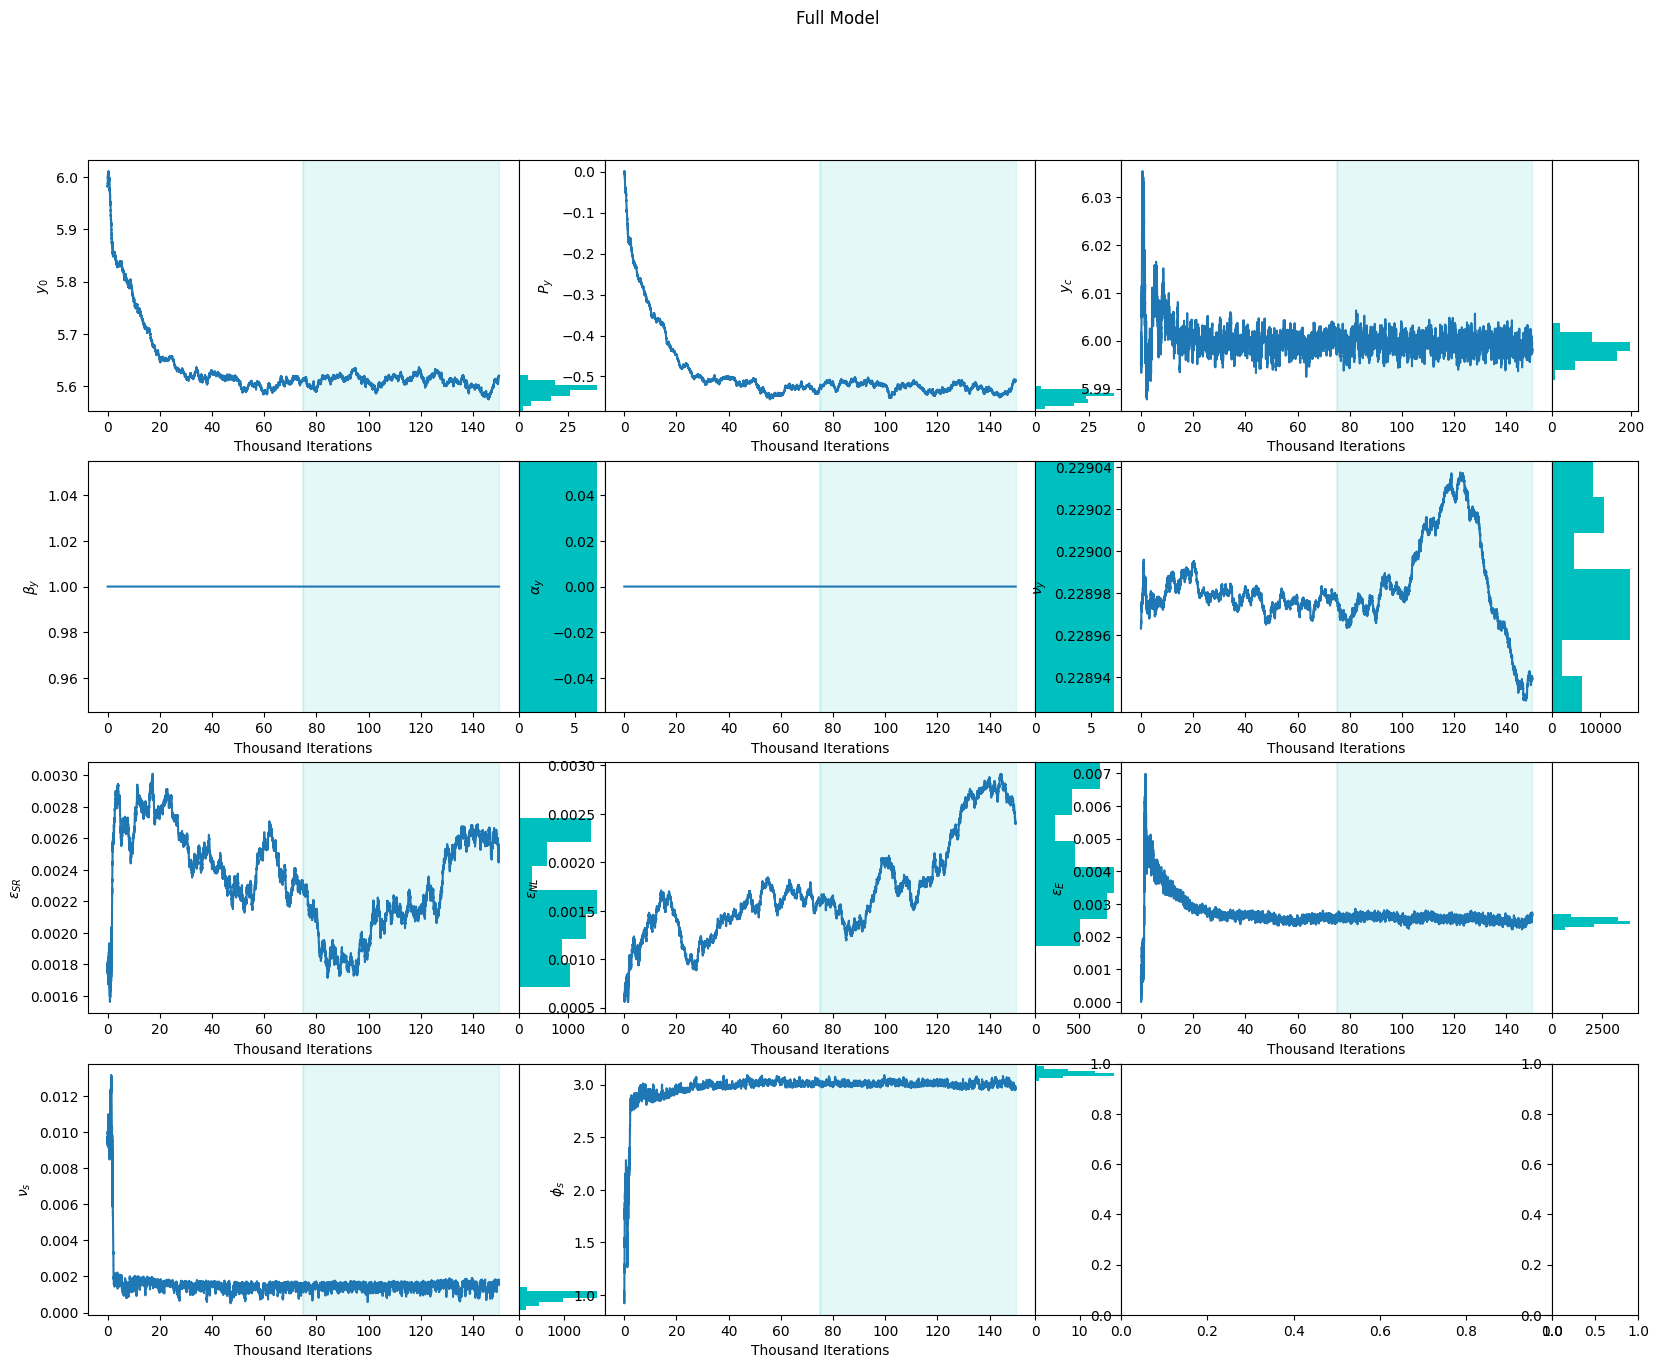

In [15]:
# Look at how variables change with # iterations
nrow = 4
ncol = 3
Theta_names = [r"$y_0$", r"$P_y$", r"$y_c$", r"$\beta_y$", r"$\alpha_y$", r"$\nu_y$", r"$\epsilon_{SR}$", 
              r"$\epsilon_{NL}$", r"$\epsilon_E$", r"$\nu_s$", r"$\phi_s$"]
N_var = len(Theta_names)
N_iter = len(parr)
fig, Ax = plt.subplots(nrow, ncol*2, gridspec_kw = {'width_ratios':[5, 1]*ncol}, figsize=(20, 15))
fig.suptitle('Full Model')
split = N_iter//2
x_iter = np.linspace(0, N_iter//1000, N_iter)
Center = []
Stddev = []

for i in range(nrow):
    for j in range(ncol):
        if i*ncol + j >= N_var:
            break
        target = parr.T[i*ncol + j]
        Ax[i][j*2].set_xlabel("Thousand Iterations")
        Ax[i][j*2].set_ylabel(Theta_names[i*ncol + j])
        Ax[i][j*2].plot(x_iter, target)
        Ax[i][j*2].axvspan(split/1000, N_iter/1000, alpha = 0.1, color = 'c')
        Ax[i][j*2].axvline(split/1000, color = 'c', alpha = 0.1)
        center, stddev = np.average(target[split:]), np.std(target[split:])
        Center.append(center)
        Stddev.append(stddev)
        
        hist_data,_,_ = Ax[i][j*2 + 1].hist(target[split:], orientation='horizontal', density=True, color='c', bins=7)
        Ax[i][j*2 + 1].set_xlim([0, np.max(hist_data)*1.1])
        Ax[i][j*2 + 1].set_ylim([np.min(target), np.max(target)])
        Ax[i][j*2 + 1].get_yaxis().set_visible(False)
        
        
plt.subplots_adjust(wspace=0.0)
plt.show()

[ 5.61025726e+00 -5.25806649e-01  5.99945132e+00  1.00000000e+00
  0.00000000e+00  2.28986283e-01  2.19319006e-03  2.00688145e-03
  2.55149619e-03  1.41838589e-03  3.00941264e+00]


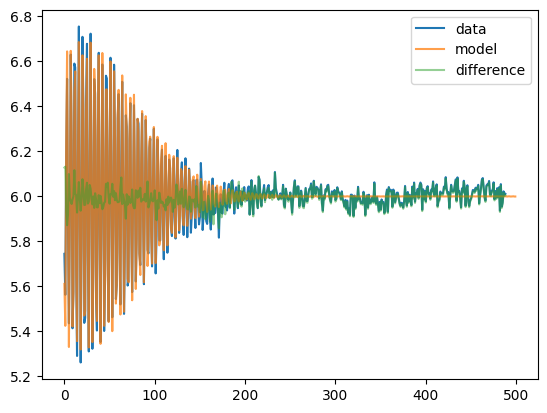

In [16]:
# Visualize Modeling for Vertical BPMs
Center = np.array(Center)
Stddev = np.array(Stddev)
print(Center)

y_model = model(*Center, N_turns)
interval = 500#N_turns//2
initial = 535
diff = BPMy0[initial:] - y_model[:len(BPMy0[initial:])] + np.mean(BPMy[0])

plt.plot(BPMy0[initial: interval + initial], label = "data")
plt.plot(y_model[:interval], label = "model", alpha = .75)
plt.plot(diff[:interval], label = "difference", alpha = .5)

plt.legend()
plt.show()

In [80]:
# Not the full circumference saves (MaxBPM/N_BPMs) of time
# Made it so that this cell only needs to be ran once even after shutting down notebook
# If want to run again to regenerate Amplitude function DELETE FILES BEFORE RERUNNING
filenamex_mean = "Theta_BPMx_mean_Data2"
filenamex_err = "Theta_BPMx_err_Data2"
MaxBPM = 50
for i in range(MaxBPM):
    BPMXi = np.abs(fft.rfft(BPMx[i])[1:])
    BPMxi_Tune_scipy = Omega[np.argmax(BPMXi)]
    pinitials_x = [BPMx[i, 0], 0.0, np.mean(BPMx[i]), 1.0, 0, BPMxi_Tune_scipy, 0,  0.0, 0, 1e-2, 0.5]
    p_step = [1e-3, 1e-3, 1e-3,  0,  0, 5e-7, 1e-4, 1e-5, 1e-5, 1e-4, 3e-2]
    sinitials = [1e-2, 0e-2]
    s_step = [2e-4, 0e-3]
    initial_x = 35
    N_iter = 100000
    begin = time.time()
    # parr : iters x 11; sarr = iters x 2
    parr, sarr = metropolis_hastings(log_likelihood, BPMx[i, initial_x: N_turns//2 + initial_x], N_iter, 
                                  pinitials_x, p_step, sinitials, s_step)
    end = time.time()
    print("Time elapsed for horizontal BPM %d:"%(i + 1), end - begin)
    with open(filenamex_mean, 'a') as csvfilex_mean:
        writerx_mean = csv.writer(csvfilex_mean, delimiter=',')
        writerx_mean.writerow(np.mean(parr.T[:, N_iter//2:], axis = 1))
    with open(filenamex_err, 'a') as csvfilex_err:
        writerx_err = csv.writer(csvfilex_err, delimiter=',')
        writerx_err.writerow(np.std(parr.T[:, N_iter//2:], axis = 1))

Time elapsed for horizontal BPM 1: 16.24721884727478
Time elapsed for horizontal BPM 2: 15.840210914611816
Time elapsed for horizontal BPM 3: 15.586149215698242
Time elapsed for horizontal BPM 4: 15.245996952056885
Time elapsed for horizontal BPM 5: 16.448545932769775
Time elapsed for horizontal BPM 6: 17.27115797996521
Time elapsed for horizontal BPM 7: 16.30243420600891
Time elapsed for horizontal BPM 8: 15.578221082687378
Time elapsed for horizontal BPM 9: 15.573216199874878
Time elapsed for horizontal BPM 10: 15.50441288948059
Time elapsed for horizontal BPM 11: 15.700334787368774
Time elapsed for horizontal BPM 12: 15.467345952987671
Time elapsed for horizontal BPM 13: 16.435638904571533
Time elapsed for horizontal BPM 14: 15.47380018234253
Time elapsed for horizontal BPM 15: 15.361524105072021
Time elapsed for horizontal BPM 16: 15.393824815750122
Time elapsed for horizontal BPM 17: 15.746420860290527
Time elapsed for horizontal BPM 18: 15.408138990402222
Time elapsed for horizon

/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_52631/1584674187.py:23: RuntimeWarning: overflow encountered in multiply
  return -np.sum(diff*diff/2.0/ss) - np.sum(np.log(np.sqrt(ss)))#*len(diff)
/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_52631/1584674187.py:23: RuntimeWarning: overflow encountered in divide
  return -np.sum(diff*diff/2.0/ss) - np.sum(np.log(np.sqrt(ss)))#*len(diff)


Time elapsed for horizontal BPM 21: 36.97357726097107
Time elapsed for horizontal BPM 22: 30.7135112285614
Time elapsed for horizontal BPM 23: 28.858729362487793
Time elapsed for horizontal BPM 24: 25.63516902923584
Time elapsed for horizontal BPM 25: 18.50934100151062
Time elapsed for horizontal BPM 26: 16.13262414932251
Time elapsed for horizontal BPM 27: 17.16912007331848
Time elapsed for horizontal BPM 28: 17.318756103515625
Time elapsed for horizontal BPM 29: 16.48112988471985
Time elapsed for horizontal BPM 30: 17.091215133666992
Time elapsed for horizontal BPM 31: 16.68502974510193
Time elapsed for horizontal BPM 32: 15.886062860488892
Time elapsed for horizontal BPM 33: 16.690455198287964
Time elapsed for horizontal BPM 34: 19.63724422454834
Time elapsed for horizontal BPM 35: 17.227073907852173
Time elapsed for horizontal BPM 36: 17.198723077774048
Time elapsed for horizontal BPM 37: 19.729734897613525
Time elapsed for horizontal BPM 38: 18.21949005126953
Time elapsed for hori

/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_52631/1584674187.py:14: RuntimeWarning: overflow encountered in exp
  decay = np.exp(-(alpha**2 - alpha02)/2 - (eps_nl*turns)**2 - eps_sr*turns)


Time elapsed for horizontal BPM 50: 15.409372329711914


In [34]:
# Run the following two cells if you already have data
def Jbeta(X, Px, N_BPMs, Bad_bpms):
    res = X**2 + Px**2

    # Get rid of bad bpms
    for i in Bad_bpms:
        # Look for the nearest good bpm neighbors and take the average:
        lo, hi = i, i
        while lo in Bad_bpms: 
            lo -= 1
            if lo < 0: lo = N_BPMs - 1
        while hi in Bad_bpms: 
            hi += 1
            if hi >= N_BPMs: hi = 0
        res[i] = (res[lo] + res[hi])/2
    return res

#Error Propagation
def Jbeta_error(X, Px, X_err, Px_err, N_BPMs, Bad_bpms, err_lim):
    A = np.sqrt(Jbeta(X, Px, N_BPMs, Bad_bpms))
    error = X_err**2*(X/A)**2 + Px_err**2*(Px/A)**2
    LargeErrorBPM = np.zeros(len(X))
    for i in range(len(error)):
        if error[i] > err_lim:
            LargeErrorBPM[i] = 1
    return np.sqrt(error), LargeErrorBPM

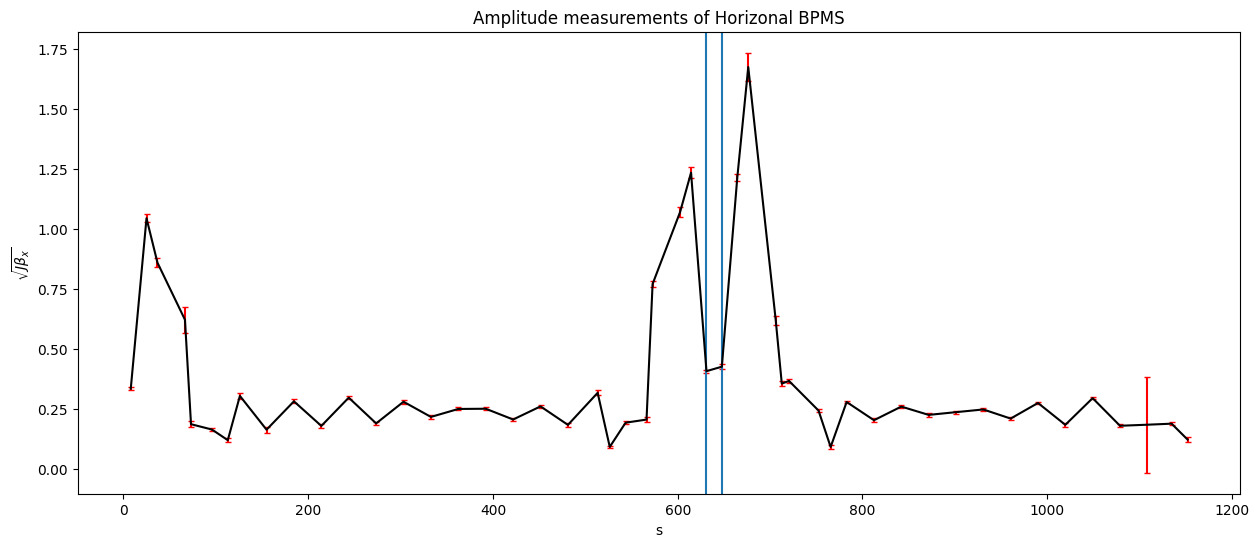

In [35]:
filenamex_mean = "Theta_BPMx_mean_Data2"
filenamex_err = "Theta_BPMx_err_Data2"
MaxBPM = 50

# Visualize Amplitude function with Error Bars
with open(filenamex_mean, newline = "") as csvfilex_mean:
    Theta_final_x = np.array(list(csv.reader(csvfilex_mean, delimiter=',')), dtype=float)
with open(filenamex_err, newline = "") as csvfilex_err:
    Theta_final_x_err = np.array(list(csv.reader(csvfilex_err, delimiter=',')), dtype=float)

X, Px = Theta_final_x.T[:2]
X_err, Px_err = Theta_final_x_err.T[:2]
err_lim = .2
Bad_BPMx = Bad_Bpms(BPMx_Tune_Map[:MaxBPM], nu_x, MaxBPM)

BPMx_Jbeta_Map = np.sqrt(Jbeta((X - np.mean(BPMx[:MaxBPM], axis = 1)), Px, MaxBPM, Bad_BPMx[:MaxBPM]))
BPMx_Jbeta_Map_err, LargeErrorBPMx = Jbeta_error(X, Px, X_err, Px_err, MaxBPM, Bad_BPMx[:MaxBPM], err_lim)

fig, ax = plt.subplots(figsize = (15, 6))
BPMx_Jbeta_Map_err_plot = np.copy(BPMx_Jbeta_Map_err)
for i, status in enumerate(LargeErrorBPMx):
    if status == 1: BPMx_Jbeta_Map_err_plot[i] = err_lim
ax.errorbar(S_xbpms[0, :MaxBPM], BPMx_Jbeta_Map, yerr = BPMx_Jbeta_Map_err_plot, color = 'k', ecolor = 'r', capsize = 2)
plt.axvline(x = S_xbpms[0, 27])
plt.axvline(x = S_xbpms[0, 28])
ax.set_xlabel("s")
ax.set_ylabel(r"$\sqrt{J\beta_x}$")
ax.set_title(r"Amplitude measurements of Horizonal BPMS")
plt.show()


# Betatron Function around IP8

Determine $\alpha$ at g7-bx:\

\begin{equation*}
M_{drift} = 
\begin{bmatrix}
C & S\\
C' & S'
\end{bmatrix}
=
\begin{bmatrix}
1 & L\\
0 & 1
\end{bmatrix}
\end{equation*}

\begin{equation*}
\Rightarrow
M_{twiss} = 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\end{equation*}

Between BPM 27 (1) and BPM 28 (2):
\begin{equation*}
\begin{bmatrix}
\beta_2 \\
\alpha_1 \\
\gamma_1 \\
\end{bmatrix}
= 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\alpha_1 \\
\gamma_1 \\
\end{bmatrix}
\end{equation*}

$\Rightarrow \beta_2 = \beta_1 - 2L\alpha_i + L^2 \gamma_i$\
$\Rightarrow \alpha_1 = \frac{\beta_1}{L} \pm \sqrt{\frac{\beta_1\beta_2}{L^2} - 1}$


$\alpha$ can also be derived from $\beta^*$ parabola formula:\
$\beta(s) = \beta^* + \frac{(s - s^*)^2}{\beta^*}$\
$\beta'(s) = \frac{2(s - s^*)}{\beta^*}$\
$\alpha_{s} = -\frac{\beta'(s)}{2} = \frac{(s^* - s)}{\beta^*}$\
$\alpha_{g7-bx} = (s^* - s_{g7-bx})/\beta^*$

Combining the two results for $\alpha$:\
$\alpha_{g7-bx} = \frac{s^* - s_{g7-bx}}{\beta^*} = \frac{\beta(s_{g7-bx})}{L} + \sqrt{\frac{\beta_1\beta_2}{L^2} - 1}$

Now solve for three nonlinear equations and three unknowns: $\beta^*, s^*, J$\
Using:\
$\beta = \frac{A}{J}$\
0 = $\beta^* + (s_{g7-bx} - s^*)^2/\beta^* - \beta(s_{g7-bx})$\
0 = $\beta^* + (s_{g8-bx} - s^*)^2/\beta^* - \beta(s_{g8-bx})$\
$\alpha_{g7-bx} = (s^* - s_{g7-bx})/\beta^*$\
0 = $\sqrt{\frac{\beta_1\beta_2}{L^2} - 1} - (\alpha_{g7-bx} - \beta(s_{g7-bx})/L_{27-28}))$

This method uses only information from g7-bx and g8-bx.\
It produces many solutions based on the guess of $\beta^*$ and J, so look at L2 error of each combination.\
Use these results to get the uncertainty of J.

In [13]:
# Predict J const using MADx
s_MADx = []
Betax_MADx = []
with open('twiss.out_Au23-100GeV-e0-beta5') as output:
    Lines = output.readlines()
    for i, line in enumerate(Lines[48:]):
        Line = re.split("\s+", line)
        Line[1] = Line[1].replace('_', '-')[1:-1]
        if Line[1] in np.char.upper(Name_xbpms) or Line[1] == 'BI9-B3.1': # because it is BI9-BH3.1 in the measurement file
            s_MADx.append(float(Line[2]))
            Betax_MADx.append(float(Line[3]))

s_MADx = np.array(s_MADx)[:MaxBPM]
Betax_MADx = np.array(Betax_MADx)[:MaxBPM]
BetaArc = []
AmpArc = []
sArc = []
for i, name in enumerate(Name_xbpms[:MaxBPM]):
    if name[0] != 'g' and name[-4:-2] == "bh" and int(name[-2:]) >= 12:
        #print(name)
        BetaArc.append(Betax_MADx[i])
        AmpArc.append(BPMx_Jbeta_Map[i])
#         print(i, BPMx_Jbeta_Map[i], Name_xbpms[i])
        sArc.append(s_MADx[i])
        
BetaArc = np.array(BetaArc)[:MaxBPM]
AmpArc = np.array(AmpArc)[:MaxBPM]
J_MADx = (sum(AmpArc)/sum(BetaArc))
print(J_MADx)


0.005448217120248207


/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_9420/2099598243.py:12: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((b27*b28/L27_28**2 - 1)) - ((sstar - s_g7_bx)/bstar - b27/L27_28)])


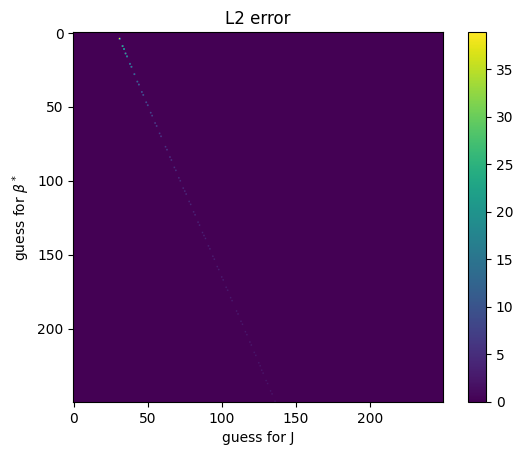

Lowest error result


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [28]:
# use Solver to solve 3 equations for 3 unknowns
s_g7_bx, s_g8_bx = S_xbpms[0, 27:29]
L27_28 = abs(s_g8_bx - s_g7_bx)
sIP8 = 639.445027949618

def f2(x):
    sstar, bstar, J = x
    b27, b28 = (BPMx_Jbeta_Map[27:29]/J)
    return np.array([
           bstar + (s_g7_bx - sstar)**2/bstar - b27, 
           bstar + (s_g8_bx - sstar)**2/bstar - b28,
           np.sqrt((b27*b28/L27_28**2 - 1)) - ((sstar - s_g7_bx)/bstar - b27/L27_28)])

#accuracy:
N_b = 250
N_J = 250

Bguess = np.linspace(.2, 1, N_b)
Jguess = np.linspace(J_MADx - .0054, J_MADx + .0054, N_J)
Err = np.zeros([N_b, N_J])

Sstar = np.zeros([N_b, N_J])
Bstar = np.zeros([N_b, N_J])
Jconst = np.zeros([N_b, N_J])
for i, b in enumerate(Bguess):
    for j, J in enumerate(Jguess):
        sstar, bstar, jconst = optimize.fsolve(f2, [sIP8, b, J])
        Err[i, j] = np.sqrt(np.sum((f2([sstar, bstar, jconst]))**2))
        Sstar[i, j] = sstar
        Bstar[i, j] = bstar
        Jconst[i, j] = jconst
c = plt.imshow(Err)
plt.title("L2 error")
plt.xlabel("guess for J")
plt.ylabel(r"guess for $\beta^*$")
plt.colorbar(c)
plt.show()

b_ind, j_ind = np.unravel_index(np.argmin(Err), Err.shape)
sstar_LE, bstar_LE, jconst_LE = optimize.fsolve(f2, [sIP8, Bguess[b_ind], Jguess[j_ind]])
print("Lowest error result")
display(Math(r"s^* = %f, \beta^* = %f, J = %f"%(sstar_LE, bstar_LE, jconst_LE)))
display(Math(r"\Delta s^* = %f"%(sstar - sIP8)))

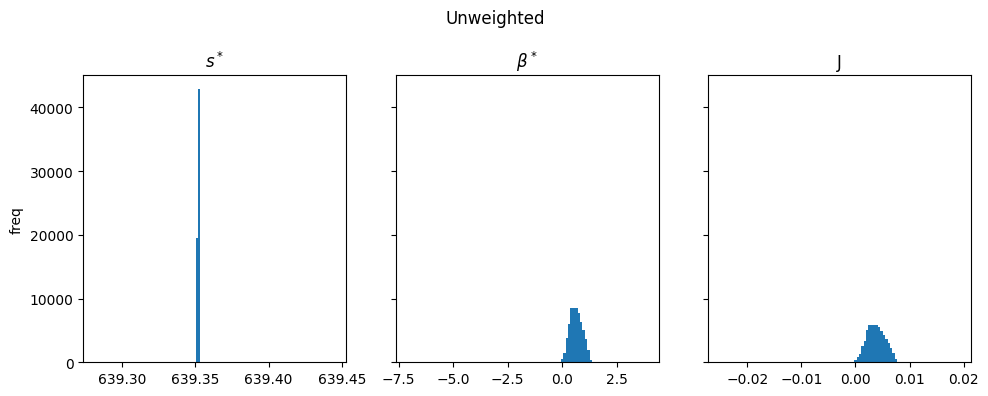

Stats:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [29]:
bins = 100
fig, axs = plt.subplots(1, 3, sharey = True, tight_layout=True, figsize = (10, 4))
plt.suptitle("Unweighted")
axs[0].hist(Sstar.flatten(), bins)
axs[1].hist(Bstar.flatten(), bins)
axs[2].hist(Jconst.flatten(), bins)
axs[0].set_ylabel("freq")
axs[0].set_title(r"$s^*$")
axs[1].set_title(r"$\beta^*$")
axs[2].set_title("J")
plt.show()
print("Stats:")

display(Math("\overline{s}^* = %f \pm %f"% (np.mean(Sstar), np.std(Sstar))))
display(Math(r"\overline{\beta}^* = %f \pm %f"% (np.mean(Bstar), np.std(Bstar))))
display(Math(r"\overline{J} = %f \pm %f"% (np.mean(Jconst), np.std(Jconst))))
display(Math(r"\Delta s^* = %f \pm %f"% (np.mean(Sstar) - sIP8, np.std(Sstar))))


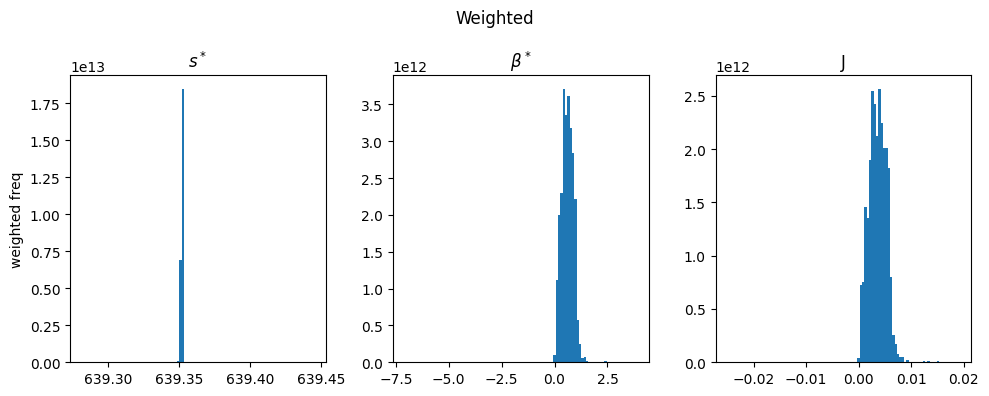

Weighted Stats:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [30]:
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize = (10, 4))
plt.suptitle("Weighted")
weight = 1/(Err.flatten() + 1e-10)
freq_Sstar_weight, bins_Sstar_weight, _ = axs[0].hist(Sstar.flatten(), bins, weights = weight)#, density = True)
freq_Bstar_weight, bins_Bstar_weight, _ = axs[1].hist(Bstar.flatten(), bins, weights = weight)#, density = True)
freq_Jconst_weight, bins_Jconst_weight, _ = axs[2].hist(Jconst.flatten(), bins, weights = weight)#, density = True)
axs[0].set_ylabel("weighted freq")
axs[0].set_title(r"$s^*$")
axs[1].set_title(r"$\beta^*$")
axs[2].set_title("J")
#axs[2].set_xlim([0, .1])
plt.show()

# Find mean and stddev of three plots
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, np.sqrt(variance)
print("Weighted Stats:")
sstar_avg_weighted, sstar_stddev_weighted = weighted_avg_and_std(bins_Sstar_weight[:-1], freq_Sstar_weight)
Bstar_avg_weighted, Bstar_stddev_weighted = weighted_avg_and_std(bins_Bstar_weight[:-1], freq_Bstar_weight)
Jconst_avg_weighted, Jconst_stddev_weighted = weighted_avg_and_std(bins_Jconst_weight[:-1], freq_Jconst_weight)
display(Math("\overline{s}^* = %f \pm %f"% (sstar_avg_weighted, sstar_stddev_weighted)))
display(Math(r"\overline{\beta}^* = %f \pm %f"% (Bstar_avg_weighted, Bstar_stddev_weighted)))
display(Math(r"\overline{J} = %f \pm %f"% (Jconst_avg_weighted, Jconst_stddev_weighted)))
display(Math(r"\Delta s^* = %f \pm %f"% (sstar_avg_weighted - sIP8, sstar_stddev_weighted)))


## Error Propagation Calculation:
### On Betatron function:
$\beta = \frac{A}{J}$\
$\Rightarrow \sigma_{\beta}^2 = (\sigma_{A}\frac{\partial \beta}{\partial A})^2 + (\sigma_{J}\frac{\partial \beta}{\partial J})^2$\
$\Rightarrow \sigma_{\beta} = \sqrt{(\sigma_{A}\frac{1}{J})^2 + (\sigma_{J}\frac{-A}{J^2})^2}$

Then calculate partial derivatives of alpha:\
$\alpha_{27} = \frac{\beta_{27}}{L} + \sqrt{\frac{\beta_{27}\beta_{28}}{L^2} - 1}$\
$\Rightarrow \frac{\partial \alpha_{27}}{\partial \beta_{27}} = \frac{1}{L} + \frac{\beta_{28}}{2L^2\sqrt{\frac{\beta_{27}\beta_{28}}{L^2} - 1}}$\
& $\frac{\partial \alpha_{27}}{\partial \beta_{28}} = \frac{\beta_{27}}{2L^2\sqrt{\frac{\beta_{27}\beta_{28}}{L^2} - 1}}$

Using these, calculate error
### On $s^*$:
$s^* = s_{g7-bx} + \frac{\alpha_{27}\beta_{27}}{\alpha_{27}^2 + 1}$\
$\Rightarrow \frac{\partial s^*}{\partial \beta_{27}} = \frac{-\frac{\partial \alpha_{27}}{\partial \beta_{27}}\alpha_{27}^2\beta_{27} + {\frac{\partial \alpha_{27}}{\partial \beta_{27}}\beta_{27} + \alpha_{27}^3 + \alpha_{27}}}{(\alpha_{27}^2 + 1)^2}$\
& $\frac{\partial s^*}{\partial \beta_{28}} = \frac{-\frac{\partial \alpha_{27}}{\partial \beta_{28}}\beta_{27}(\alpha_{27}^2 - 1)}{(\alpha_{27}^2 + 1)^2}$
    
$\therefore \sigma_{s^*}^2 = (\sigma_{\beta_{27}}\frac{\partial s^*}{\partial \beta_{27}})^2 + (\sigma_{\beta_{28}}\frac{\partial s^*}{\partial \beta_{28}})^2$

### And $\beta^*$:
$\beta^* = \frac{\beta_{27}}{\alpha_{27}^2 + 1}$\
$\Rightarrow \frac{\partial \beta^*}{\partial \beta_{27}} = \frac{-2\frac{\partial \alpha_{27}}{\partial \beta_{27}}\alpha_{27}\beta_{27} + \alpha_{27}^2 + 1}{(\alpha_{27}^2 + 1)^2}$\
& $\frac{\partial \beta^*}{\partial \beta_{28}} = \frac{-2\frac{\partial \alpha_{27}}{\partial \beta_{28}}\alpha_{27}\beta_{27}}{(\alpha_{27}^2 + 1)^2}$

$\therefore \sigma_{\beta^*}^2 = (\sigma_{\beta_{27}}\frac{\partial \beta^*}{\partial \beta_{27}})^2 + (\sigma_{\beta_{28}}\frac{\partial \beta^*}{\partial \beta_{28}})^2$


<IPython.core.display.Math object>

Propagated error of Beta function at g7-bx & g8-bx based on varying J: 


<IPython.core.display.Math object>

Propagated error of star values based on varying Beta function at g7-bx & g8-bx: 


<IPython.core.display.Math object>

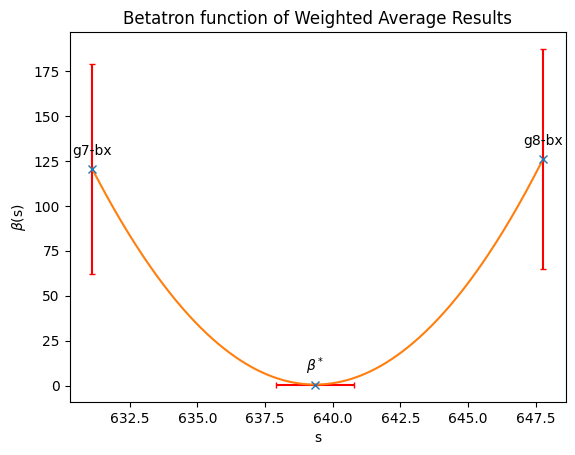

In [31]:
def calc_parabola_vertex(x1, y1, x2, y2, x3, y3):
    denom = (x1-x2) * (x1-x3) * (x2-x3)
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
    C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom
    return A,B,C

beta_BPM27, beta_BPM28 = BPMx_Jbeta_Map[27:29]/Jconst_avg_weighted
A, B, C = calc_parabola_vertex(s_g7_bx, beta_BPM27, sstar_avg_weighted, Bstar_avg_weighted, s_g8_bx, beta_BPM28)
A_shift, B_shift, C_shift = calc_parabola_vertex(s_g7_bx - sstar_avg_weighted, beta_BPM27, 0, Bstar_avg_weighted, s_g8_bx - sstar_avg_weighted, beta_BPM28)
display(Math(r"\beta(s) = %fs^2 + %ds + %f"%(A_shift, B_shift, C_shift)))

s_space = np.linspace(s_g7_bx, s_g8_bx, 500)
Betatron = A*s_space**2 + B*s_space + C
s_points = [s_g7_bx, sstar_avg_weighted, s_g8_bx]
b_points = [beta_BPM27, Bstar_avg_weighted, beta_BPM28]

for x, y, text in zip(s_points, b_points, 
                      [Name_xbpms[27], r"$\beta^*$", Name_xbpms[28]]):
    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
err_ypoints = np.zeros(3)
err_xpoints = np.zeros(3)

## Error Propagation on beta(s) = A/J
## s_b = sqrt((s_A*(1/J))^2 + (s_J*(-A/J^2))^2)
err_ypoints_beta = np.sqrt((BPMx_Jbeta_Map_err[27:29]*(1/Jconst_avg_weighted))**2 + (Jconst_stddev_weighted*BPMx_Jbeta_Map[27:29]/Jconst_avg_weighted**2)**2)
def error_prop_bsstar(b27, b28, b27_err, b28_err):
    a27 = b27/L27_28 + np.sqrt(b27*b28/L27_28**2 - 1)
    da27db27 = 1/L27_28 + b28/(2*L27_28**2*np.sqrt((b28*b27)/L27_28**2 - 1))
    da27db28 = b27/(2*L27_28**2*np.sqrt((b28*b27)/L27_28**2 - 1))
    
    s_star = s_g7_bx + a27*b27/(a27**2 + 1)
    ds_stardb27 = (-da27db27*a27**2*b27 + da27db27*b27 + a27**3 + a27)/(a27**2 + 1)**2
    ds_stardb28 = -da27db28*b27*(a27**2 - 1)/(a27**2 + 1)**2
#     print(s_star, sstar_avg_weighted)
    
    beta_star = b27/(a27**2 + 1)
    db_stardb27 = (-2*da27db27*a27*b27 + a27**2 + 1)/(a27**2 + 1)**2
    db_stardb28 = -2*da27db28*a27*b27/(a27**2 + 1)**2
#     print(beta_star, Bstar_avg_weighted)
    
    s_star_err_prop = np.sqrt((b27_err*ds_stardb27)**2 + (b28_err*ds_stardb28)**2)
    b_star_err_prop = np.sqrt((b27_err*db_stardb27)**2 + (b28_err*db_stardb28)**2)
    return s_star_err_prop, b_star_err_prop

print("Propagated error of Beta function at g7-bx & g8-bx based on varying J: ")
s_star_err_prop, b_star_err_prop = error_prop_bsstar(beta_BPM27, beta_BPM28, *err_ypoints_beta)
display(Math(r"\sigma_{\beta_{g7-bx}} = %f; \sigma_{\beta_{g8-bx}} = %f"%(err_ypoints_beta[0], err_ypoints_beta[1])))
print("Propagated error of star values based on varying Beta function at g7-bx & g8-bx: ")
display(Math(r"\sigma_{s^*} = %f; \sigma_{\beta^*} = %f"%(s_star_err_prop, b_star_err_prop)))
err_ypoints[0] = err_ypoints_beta[0]
err_ypoints[1] = b_star_err_prop #Bstar_stddev_weighted
err_ypoints[2] = err_ypoints_beta[1]
err_xpoints[1] = s_star_err_prop #sstar_stddev_weighted

plt.errorbar(s_points, b_points, xerr = err_xpoints, yerr = err_ypoints, fmt = 'x', ecolor = 'r', capsize = 2)
plt.plot(s_space, Betatron)
plt.title("Betatron function of Weighted Average Results")
plt.xlabel("s")
plt.ylabel(r"$\beta$(s)")
#plt.set_xlim([639, 640])
#plt.set_ylim([0, 1])
plt.show()

## Comparing Guillaume's values with my values

After shift:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

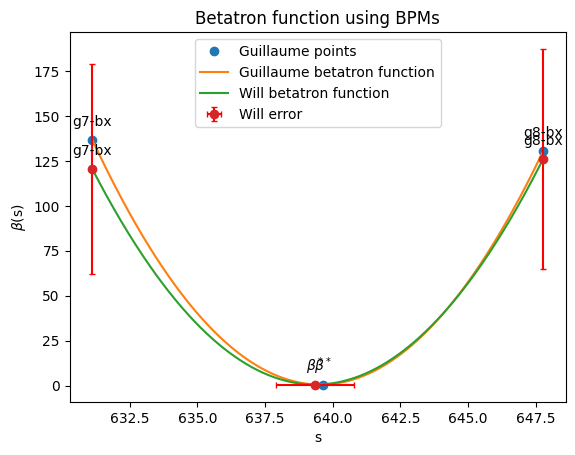

In [32]:
b1_g = 11.7**2

ss_g = .19918869 + sIP8
bs_g = .55506391

b2_g = 11.42**2

A_g, B_g, C_g = calc_parabola_vertex(s_g7_bx, b1_g, ss_g, bs_g, s_g8_bx, b2_g)
A_shift_g, B_shift_g, C_shift_g = calc_parabola_vertex(s_g7_bx - ss_g, b1_g, 0, bs_g, s_g8_bx - ss_g, b2_g)
print("After shift:")
display(Math(r"Guillaume: %fx^2 + %dx + %f"%(A_shift_g, B_shift_g, C_shift_g)))
display(Math(r"Will: %fx^2 + %dx + %f"%(A_shift, B_shift, C_shift)))

s_points_g = [s_g7_bx, ss_g, s_g8_bx]
b_points_g = [b1_g, bs_g, b2_g]
plt.plot(s_points_g, b_points_g, 'o', label = "Guillaume points")
for x, y, text in zip(s_points_g, b_points_g, [Name_xbpms[27], r"$\beta^*$", Name_xbpms[28]]):

    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x, y, text in zip(s_points, b_points, [Name_xbpms[27], r"$\beta^*$", Name_xbpms[28]]):

    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

Betatron_g = A_g*s_space**2 + B_g*s_space + C_g
plt.plot(s_space, Betatron_g, label = "Guillaume betatron function")
plt.plot(s_space, Betatron, label = "Will betatron function")
plt.errorbar(s_points, b_points, xerr = err_xpoints, yerr = err_ypoints, fmt = 'o', ecolor = 'r', capsize = 2, label = "Will error")
plt.title("Betatron function using BPMs")
plt.xlabel("s")
plt.ylabel(r"$\beta$(s)")
# plt.xlim([639, 640])
# plt.ylim([0, 1])
plt.legend()
plt.show()